In [1]:
from Functions1 import LoadData
from Functions1 import TestStrategy
from Functions1 import DynamicBacktest
import os
import pandas as pd
import yfinance as yf
import itertools
import random
import matplotlib.pyplot as plt

### Carga de datos

In [2]:
current_directory = os.getcwd()
path = os.path.join(current_directory, 'Stocks_financials')

loader = LoadData(path)
prices, financials = loader.Load(start_date='2005-09-01', end_date=None)

Data processed for the following tickers: AAPL, ABBV, ADM, ADSK, AFL, AMD, AMZN, CAT, CL, COST, CRM, CVX, DE, DOW, DUK, GE, GOOGL, GS, HD, HON, JNJ, JPM, KO, LMT, MCD, MDLZ, META, MMM, MRK, MSFT, NEE, NFLX, NVDA, PEP, PG, PLD, QCOM, RTX, SO, SRE, T, TGT, TRYIY, TSLA, TXN, V, VMC, VZ, WMT, XOM, ZBH


In [4]:
prices['AAPL']

Date
2005-09-01      1.652143
2005-09-02      1.650714
2005-09-06      1.742857
2005-09-07      1.738571
2005-09-08      1.777857
                 ...    
2024-10-23    230.759995
2024-10-24    230.570007
2024-10-25    231.410004
2024-10-28    233.399994
2024-10-29    233.669998
Name: Close, Length: 4822, dtype: float64

### Escenario unico

In [11]:
offensive_tickers = ["MSFT", "AAPL", "GOOGL", 'V', 'NFLX', 'SO', 'DUK', 'VZ', 'T', 'CVX', 'VMC', 'NVDA', 'GE', 'KO', 'JNJ', 'HD', 'AMD', 'ADM', 'META', 'TSLA', 'XOM']   
defensive_tickers = ['COST', 'DUK', 'JNJ', 'KO', 'LMT']      
canary_tickers = ['MSFT', 'V', 'NFLX', 'SO', 'DUK', 'PLD', 'VZ', 'T', 'CVX', 'VMC', 'NVDA', 'GE',
                      'KO', 'JNJ', 'GS', 'HD', 'AMD', 'ADM', 'META', 'GOOGL', 'TSLA', 'JPM', 'XOM', 'AAPL']    

In [12]:
strategy = TestStrategy(prices, financials, offensive_tickers, defensive_tickers, canary_tickers)
chosen_universe = strategy.run_strategy(start_date='2005-09-01')
chosen_universe.head(8)

,Date,Chosen Universe,Selected Stocks
0,2006-09-01,Defensive,"[COST, DUK, JNJ, KO, LMT]"
1,2007-03-01,Offensive,"[CVX, HD, ADM, XOM, MSFT, AAPL, GOOGL, NFLX]"
2,2007-09-01,Offensive,"[DUK, CVX, HD, XOM, ADM, MSFT, AAPL, GOOGL]"
3,2008-03-01,Offensive,"[DUK, CVX, HD, XOM, ADM, MSFT, AAPL, GOOGL]"
4,2008-09-01,Defensive,"[COST, DUK, JNJ, KO, LMT]"
5,2009-03-01,Defensive,"[COST, DUK, JNJ, KO, LMT]"
6,2009-09-01,Defensive,"[COST, DUK, JNJ, KO, LMT]"
7,2010-03-01,Offensive,"[SO, T, CVX, JNJ, ADM, AMD, MSFT, AAPL]"


In [13]:
benchmark_df = yf.download('^GSPC', start=chosen_universe['Date'].min(), end=chosen_universe['Date'].max(), progress=False)
benchmark_data =  benchmark_df['Adj Close']

In [14]:
backtest = DynamicBacktest(results = chosen_universe , prices = prices, initial_capital = 1_000_000, benchmark_data=benchmark_data, benchmark_ticker='^GSPC')
port_values = backtest.get_portfolio_values()
port_values

,Date,Sortino Portfolio Value,Benchmark Portfolio Value
0,2006-09-01,1.000000e+06,1.000000e+06
1,2006-09-02,1.000000e+06,1.000000e+06
2,2006-09-03,1.000000e+06,1.000000e+06
3,2006-09-04,1.000000e+06,1.000000e+06
4,2006-09-05,9.987625e+05,1.001709e+06
...,...,...,...
6569,2024-08-26,8.798373e+06,4.284361e+06
6570,2024-08-27,8.796362e+06,4.291195e+06
6571,2024-08-28,8.742109e+06,4.265551e+06
6572,2024-08-29,8.808096e+06,4.265383e+06


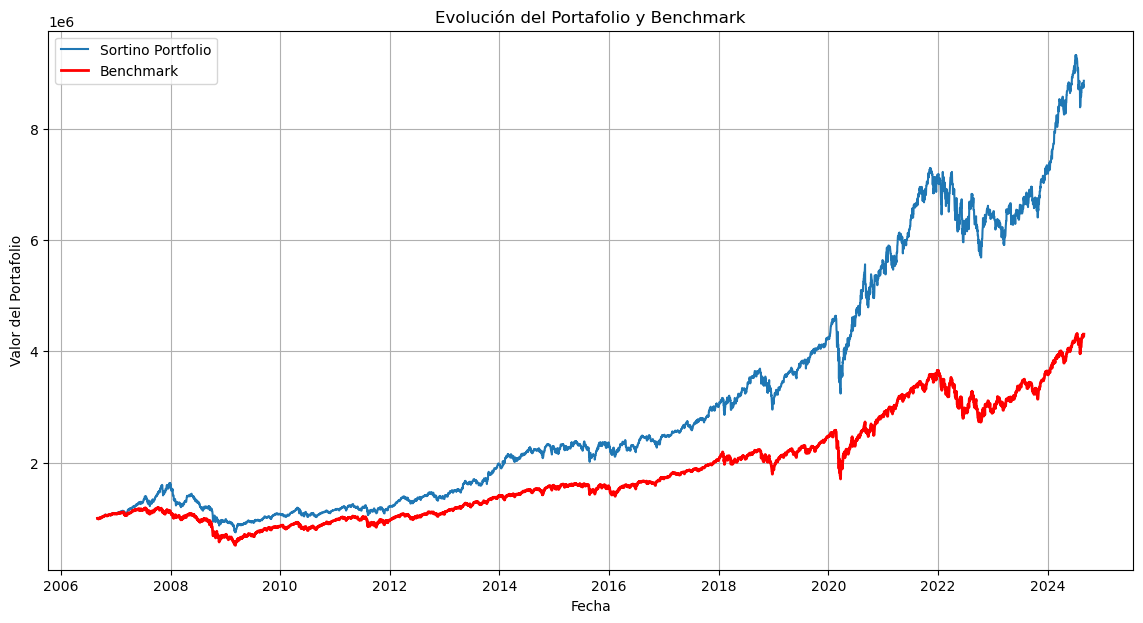

In [15]:
backtest.plot_strategies()

In [16]:
backtest.evaluate_portfolios().T

,Sortino,Benchmark
mean_return,0.096944,0.069651
CAGR,0.087227,0.057585
Sharpe Ratio,0.594852,NaN
Sortino Ratio,0.646526,NaN
Volatility,0.162971,0.164993
Semivariance,0.042201,NaN
VaR (5%),-0.016295,NaN
Beta,0.833515,NaN
Max Drawdown,-0.542936,-0.567754
Tracking Error,0.091705,NaN


-------

### Simulaciones del metodo con Portafolios aleatorios

In [23]:
offensive_tickers = ['AAPL', 'ADM', 'ADSK', 'AMD', 'CAT', 'CRM', 'CVX', 'DE', 'DOW', 'GE', 'GOOGL', 'HD', 'HON',
                     'MMM', 'MSFT', 'NFLX', 'NVDA', 'QCOM', 'RTX', 'TGT', 'TRYIY', 'TSLA', 'TXN', 'V', 'VMC', 'XOM']

defensive_tickers = ['CL', 'COST', 'DUK', 'JNJ', 'KO', 'LMT', 'MCD', 'MDLZ', 'MRK', 'PG', 'SO',
 'SRE', 'T', 'VZ', 'WMT', 'ZBH'] 

canary_tickers = [
    # Tecnología
    'AAPL', 'MSFT', 'NVDA',
    # Finanzas
    'JPM', 'GS',
    # Energía
    'XOM', 'CVX',
    # Consumo Discrecional
    'TSLA', 'HD', 'AMZN',
    # Consumo Básico
    'PG', 'KO', 'PEP',
    # Salud
    'JNJ', 'ABBV',
    # Industriales
    'CAT', 'HON', 'MMM',
    # Telecomunicaciones
    'VZ', 'T',
    # Bienes Raíces
    'PLD',
    # Materiales
    'VMC',
    # Utilidades
    'NEE', 'DUK'
]

In [25]:
n_portfolios = 100

def get_random_combinations(tickers, n, sample_size):
    """Genera combinaciones aleatorias de tickers."""
    try:
        return random.sample(list(itertools.combinations(tickers, n)), sample_size)
    except ValueError as e:
        print(f"Error while generating combinations: {e}")
        return []

# Generación de combinaciones ofensivas y defensivas
offensive_combinations = get_random_combinations(offensive_tickers, 16, n_portfolios)
defensive_combinations = get_random_combinations(defensive_tickers, 5, n_portfolios)

results = []

for offensive_combo, defensive_combo in zip(offensive_combinations, defensive_combinations):
    try:
        strategy = TestStrategy(prices, financials, list(offensive_combo), list(defensive_combo), canary_tickers)
        chosen_universe = strategy.run_strategy(start_date='2005-09-01')
        
        # Solo Sortino para ofensivo y semivarianza para defensivo
        backtest = DynamicBacktest(
            results=chosen_universe, prices=prices, initial_capital=1_000_000, 
            benchmark_data=benchmark_data, benchmark_ticker='^GSPC'
        )
        port_values = backtest.get_portfolio_values()
        evaluation = backtest.evaluate_portfolios().T

        results.append({
            'Offensive Combination': offensive_combo,
            'Defensive Combination': defensive_combo,
            'Evaluation': evaluation
        })

    except Exception as e:
        print(f"Error with offensive {offensive_combo} and defensive {defensive_combo}: {str(e)}")


final_results = pd.DataFrame(results)

In [26]:
all_evaluations = pd.concat([result['Evaluation'] for result in results], keys=range(len(results)))

# Promedio de evaluaciones
average_evaluation = all_evaluations.groupby(level=1).mean()

# Resumen de métricas clave
metric_summary = pd.DataFrame({
    'Offensive Combination': [result['Offensive Combination'] for result in results],
    'Defensive Combination': [result['Defensive Combination'] for result in results],
    'Sharpe Ratio': [result['Evaluation'].loc['Sharpe Ratio', 'Sortino'] for result in results],
    'CAGR': [result['Evaluation'].loc['CAGR', 'Sortino'] for result in results],
    'Max Drawdown': [result['Evaluation'].loc['Max Drawdown', 'Sortino'] for result in results]
})

# Seleccionar los mejores portafolios
best_sharpe_portfolio = metric_summary.loc[metric_summary['Sharpe Ratio'].idxmax()]
best_cagr_portfolio = metric_summary.loc[metric_summary['CAGR'].idxmax()]
best_drawdown_portfolio = metric_summary.loc[metric_summary['Max Drawdown'].idxmin()]


In [32]:

def plot_average_vs_benchmark(average_evaluation, benchmark_data):
    plt.figure(figsize=(14, 7))
    plt.plot(average_evaluation.index, average_evaluation['CAGR'], label='Average Portfolio CAGR', linewidth=2)
    plt.plot(benchmark_data.index, benchmark_data.pct_change().cumsum(), label='Benchmark (Cumulative)', color='red', linewidth=2)
    plt.title('Average Portfolio vs. Benchmark Performance')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.grid()
    plt.show()

plot_average_vs_benchmark(average_evaluation, benchmark_data)

KeyError: 'CAGR'

<Figure size 1400x700 with 0 Axes>

--------

In [28]:
prices['META']

Date
2012-05-18     38.230000
2012-05-21     34.029999
2012-05-22     31.000000
2012-05-23     32.000000
2012-05-24     33.029999
                 ...    
2024-10-22    582.010010
2024-10-23    563.690002
2024-10-24    567.780029
2024-10-25    573.250000
2024-10-28    579.229980
Name: Close, Length: 3131, dtype: float64

In [13]:
ratios_to_check = [
    'Return on Common Equity',
    'Operating Margin',
    'Cash Flow per Share',
    'Current Ratio (x)',
    'Total Debt/Equity (%)',
    'Total Shares Outstanding  (M)',
    'Price/Earnings'
]

tickers_with_all_ratios = []

for ticker, df in financials.items():
    if all(ratio in df['Financial Ratio'].values for ratio in ratios_to_check):
        tickers_with_all_ratios.append(ticker)

tickers_with_all_ratios

['AAPL',
 'ABBV',
 'ADM',
 'ADSK',
 'AMD',
 'CAT',
 'CL',
 'CRM',
 'CVX',
 'DE',
 'DOW',
 'DUK',
 'GE',
 'GOOGL',
 'HD',
 'HON',
 'JNJ',
 'KO',
 'LMT',
 'MCD',
 'MDLZ',
 'META',
 'MMM',
 'MRK',
 'MSFT',
 'NEE',
 'NFLX',
 'NVDA',
 'PEP',
 'PG',
 'QCOM',
 'RTX',
 'SO',
 'SRE',
 'T',
 'TGT',
 'TRYIY',
 'TSLA',
 'TXN',
 'V',
 'VMC',
 'VZ',
 'WMT',
 'XOM',
 'ZBH']

In [14]:
all_tickers = [
    'AAPL', 'ABBV', 'ADM', 'ADSK', 'AFL', 'AMD', 'CAT', 'CL', 'COST', 'CRM', 'CVX',
    'DE', 'DOW', 'DUK', 'GE', 'GOOGL', 'GS', 'HD', 'HON', 'JNJ', 'JPM', 'KO', 'LMT', 
    'MCD', 'MDLZ', 'META', 'MMM', 'MRK', 'MSFT', 'NFLX', 'NVDA', 'PG', 'PLD', 'QCOM', 
    'RTX', 'SO', 'SRE', 'T', 'TGT', 'TRYIY', 'TSLA', 'TXN', 'V', 'VMC', 'VZ', 'WMT', 
    'XOM', 'ZBH'
]

tickers_without_all_ratios = [ticker for ticker in all_tickers if ticker not in tickers_with_all_ratios]
tickers_without_all_ratios

['AFL', 'COST', 'GS', 'JPM', 'PLD']

In [15]:
tickers_to_check = [
    'ABBV', 'CL', 'COST', 'DUK', 'JNJ', 'KO', 'LMT', 'MCD', 'MDLZ', 'MRK', 
    'PG', 'SO', 'SRE', 'T', 'VZ', 'WMT', 'ZBH'
]

tickers_with_initial_date = []

for ticker in tickers_to_check:
    first_date = pd.to_datetime(prices[ticker].index[0])
    
    if first_date == pd.to_datetime('2005-09-01'):
        tickers_with_initial_date.append(ticker)

tickers_with_initial_date

['CL',
 'COST',
 'DUK',
 'JNJ',
 'KO',
 'LMT',
 'MCD',
 'MDLZ',
 'MRK',
 'PG',
 'SO',
 'SRE',
 'T',
 'VZ',
 'WMT',
 'ZBH']

In [16]:
missing_tickers = [ticker for ticker in canary_tickers if ticker not in all_tickers]

missing_tickers

['AMZN', 'PEP', 'NEE']